# SpaceTimeLabs

In [6]:
from os import makedirs, path, getcwd, listdir
from zipfile import ZipFile
from tqdm import tqdm 

def unzip_files(file_name, input_dir, output_dir):
    # Create the output directory if it doesn't exist
    makedirs(output_dir, exist_ok=True)
    
    if file_name.endswith('.zip'):
        # Get the full path of the zip file
        zip_file_path = path.join(input_dir, file_name)

        # Open the zip file
        with ZipFile(zip_file_path, 'r') as zip_ref:
            # Extract all files to the output directory
            zip_ref.extractall(output_dir)

        print(f"Extracted {file_name} to {output_dir}")

input_directory = getcwd() + '/data/temperatura_zip' 

# Loop through all files in the input directory
for file_name in tqdm(listdir(input_directory)):
    folder_name = file_name.split('.')[0]
    
    # Example usage
    output_directory = getcwd() + '/data/temperatura/' + folder_name
    unzip_files(file_name, input_directory, output_directory)

FileNotFoundError: [Errno 2] No such file or directory: '/media/brunolnetto/spacetime_labs/data/temperatura_zip'

## Questão 1

Faça uma **análise histórica** da evolução anual dos valores de:

1. **área plantada**; 
2. **produção**;
3. **produtividade**. 

por estado brasileiro.

Dados disponíveis em: https://www.conab.gov.br/info-agro/safras/serie-historica-das-safras/itemlist/category/911-soja

In [33]:
def get_geodata(df_):
    states, regions, economical_regions, country = get_geolocalities(df_)
    years = get_years(df_)
    
    label_uf = df_.columns[0]
    
    has_2_mask = df_[label_uf].str.len() == 2
    has_not_2_mask = df_[label_uf].str.len() != 2
    
    is_region = df_[label_uf].isin(regions)
    is_eregion = df_[label_uf].isin(economical_regions)
    is_country = df_[label_uf].isin(country)

    uf_mask = has_2_mask
    region_mask = is_region
    eregion_mask = is_eregion
    brazil_mask = is_country

    df_soy_states = df_[uf_mask]
    df_soy_region = df_[region_mask]
    df_soy_eregion = df_[eregion_mask]
    df_soy_country = df_[brazil_mask]
    
    uf_region = ['UF']+years
    region_column = ['region']+years
    country_column = ['country']+years

    df_soy_states.columns = uf_region
    df_soy_region.columns = region_column
    df_soy_eregion.columns = region_column
    df_soy_country.columns = country_column
    
    return df_soy_states, df_soy_region, df_soy_eregion, df_soy_country
    
def try_float_cast_coalesce_zero(value):
    value = str(value).strip()

    try:
        return float(value)
    except ValueError:
        return 0
    
def get_timeseries_label(df_, label):
    descriptive_column = df_.columns[0]
    non_descriptive_columns = df_.columns[1:]
    label_mask = df_[descriptive_column] == label
    
    df_label = df_[label_mask]
    
    values = []
    for irow, row in df_label.iterrows():
        
        values = [
            try_float_cast_coalesce_zero(row[col])
            for col in non_descriptive_columns
        ]
    
    return values

def get_years(df_):
    years = df_.columns[1:]
    
    return [int(year.split('/')[0]) for year in years]

def get_timeseries_labels(df_, labels):
    years = [int(val) for val in df_.columns[1:]]
    
    return {label: get_timeseries_label(df_, label) for label in labels} 
    
def plot_soy_data(label, x, y_dict, y_label):
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plotagem individual 
    axs[0].set_title('Individual')
    for key, values in y_dict.items():
        axs[0].plot(x, values, label=key)
    
    axs[0].set_xlabel('Tempo [Anos]')
    axs[0].set_ylabel(y_label)
    axs[0].legend(title='Legend', loc='upper left')
    
    # Plotagem Acumulada
    axs[1].set_title('Acumulada')
    axs[1].stackplot(x, y_dict.values(), labels=y_dict.keys())
    
    axs[0].set_xlabel('Tempo [Anos]')
    axs[0].set_ylabel(y_label)
    axs[0].legend(title='Legend', loc='upper left')

    plt.suptitle(f'{y_label} por {label}')
    plt.tight_layout()
    plt.show()

def get_geolocalities(df_):
    label_uf = df_.columns[0]
    
    has_2_mask = df_[label_uf].str.len() == 2
    has_not_2_mask = df_[label_uf].str.len() != 2
    
    regions_list = list(df_[has_not_2_mask][label_uf])
    states = list(df_[has_2_mask][label_uf])
    regions = regions_list[0:5]
    economical_regions = regions_list[5:7]
    country = [regions_list[7]]
    
    return states, regions, economical_regions, country

def get_data_labels(df_):
    years = get_years(df_)
    states, regions, eregions, country = get_geolocalities(df_)
    
    return years, states, regions, eregions, country

def get_soy_data(froute):
    return pd.read_csv(froute, delimiter=',', encoding='utf8')

def read_soy_data(froute):
    df_soy = get_soy_data(froute)
    years, states, regions, eregions, country = get_data_labels(df_soy)
    df_soy_states, df_soy_regions, df_soy_eregions, df_soy_country = get_geodata(df_soy)
    
    return {
        'estados': get_timeseries_labels(df_soy_states, states),
        'regiões políticas': get_timeseries_labels(df_soy_regions, regions),
        'regiões econômicas': get_timeseries_labels(df_soy_eregions, eregions),
        'país': get_timeseries_labels(df_soy_country, country)
    }


In [34]:
froute = getcwd() + '/data/soy_area.csv'

df_soy = get_soy_data(froute)
years, states, regions, eregions, country = get_data_labels(df_soy)


In [35]:
import pandas as pd
from os import getcwd

fpath = getcwd() + '/data/'
fnames = [
    'soy_area.csv',
    'soy_productivity.csv',
    'soy_production.csv'
]

for fname in fnames:
    froute = fpath + fname

    soy_data = {
        fname: read_soy_data(fpath + fname) 
        for fname in fnames
    }

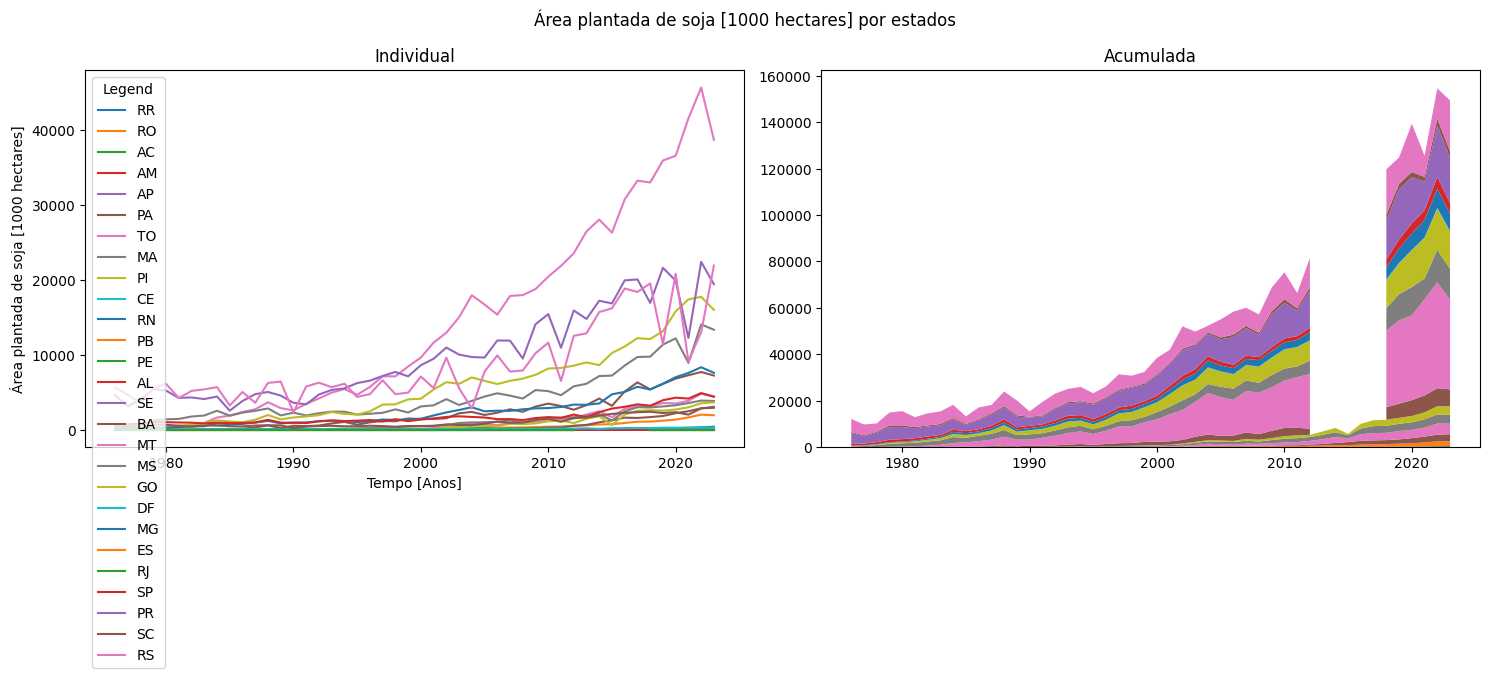

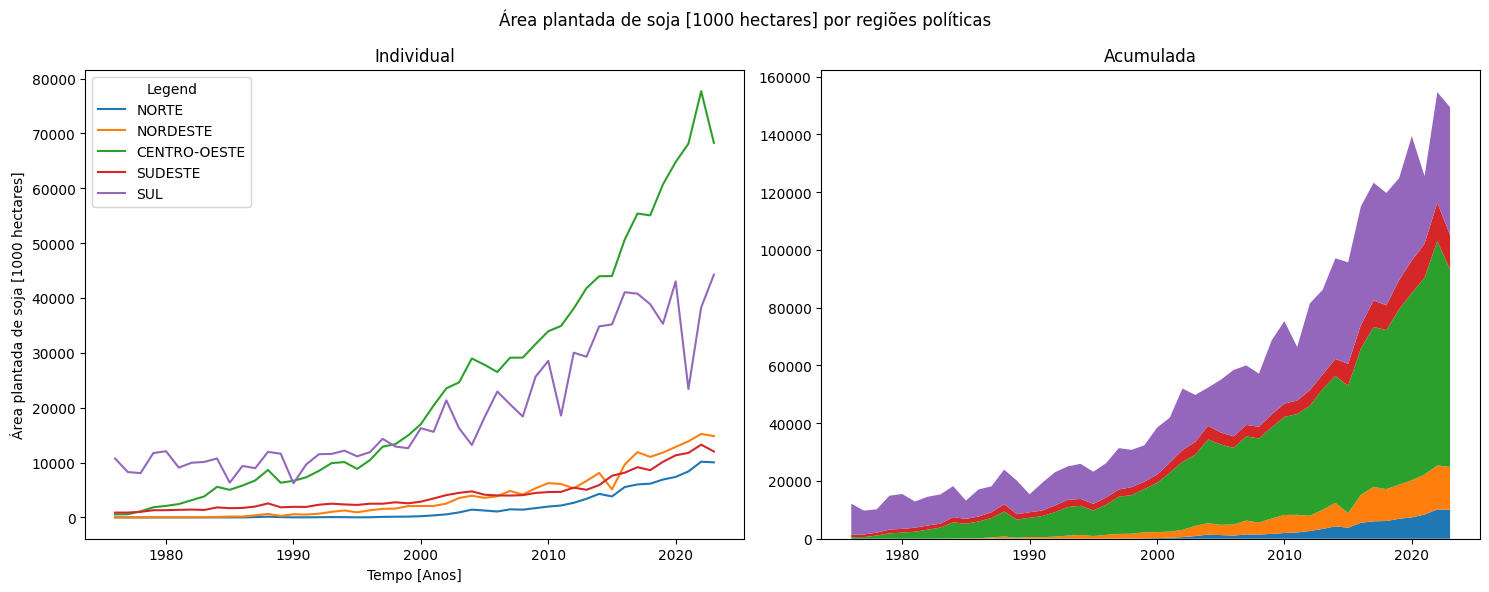

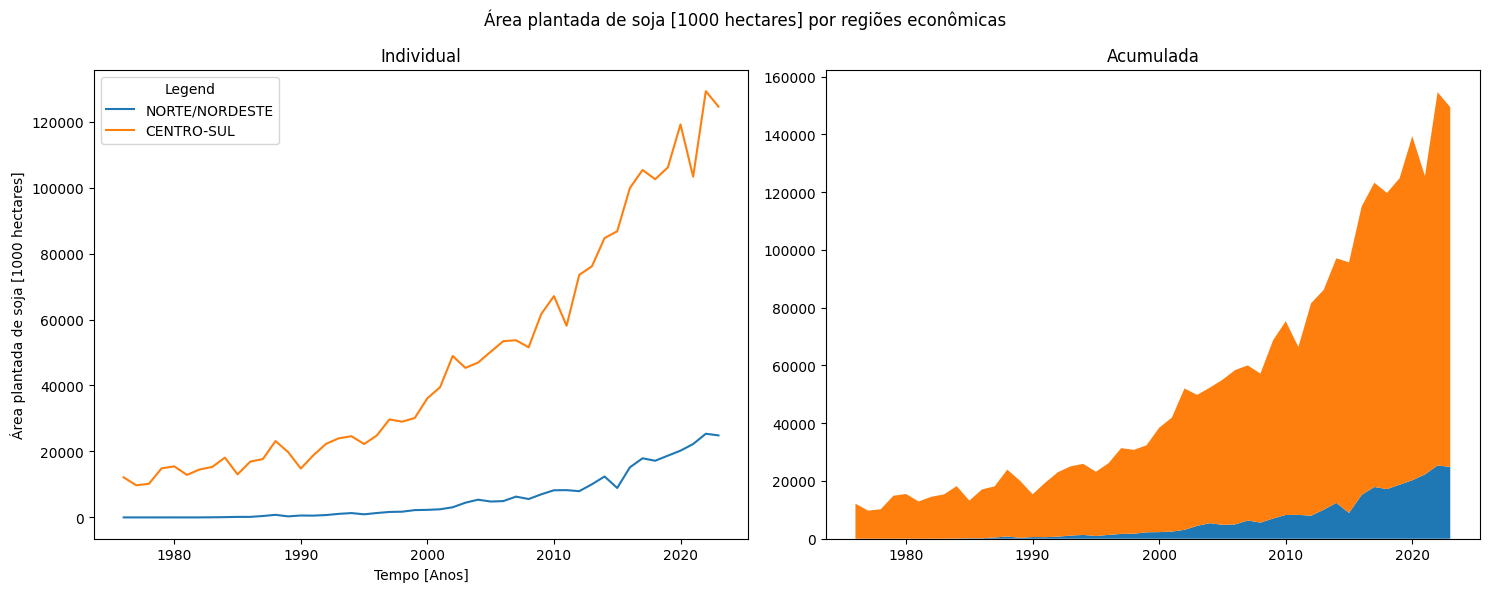

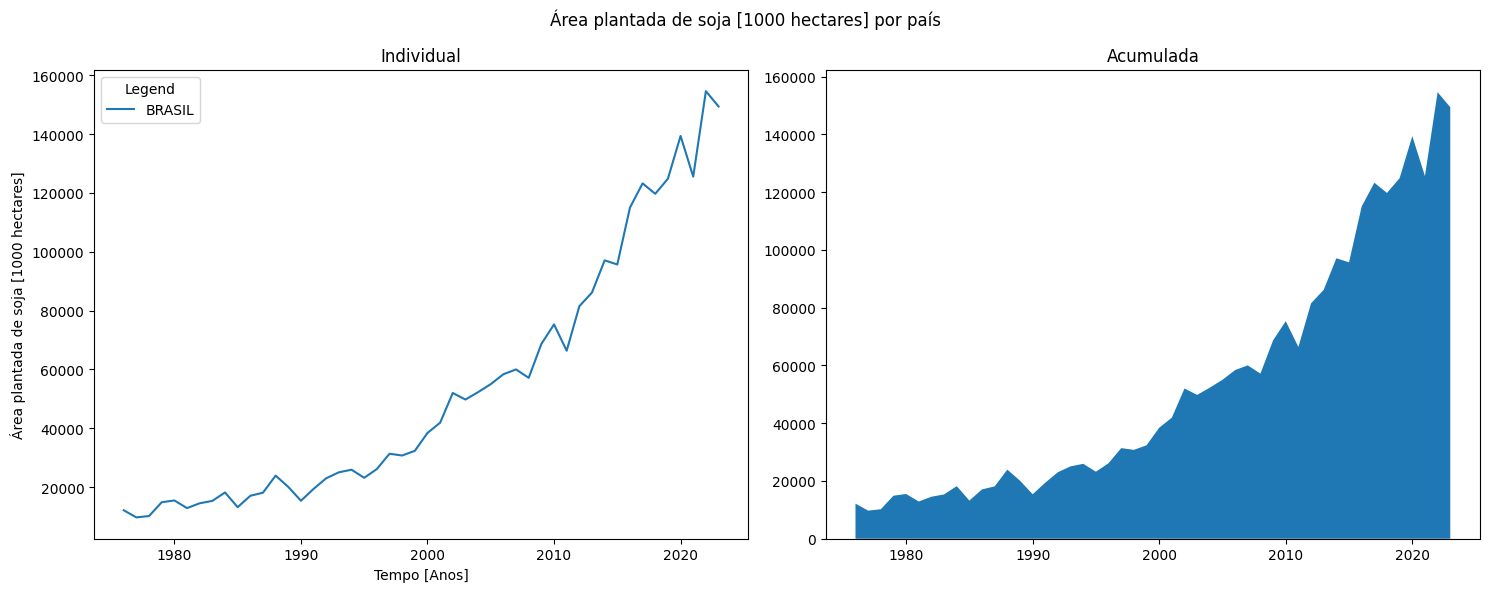

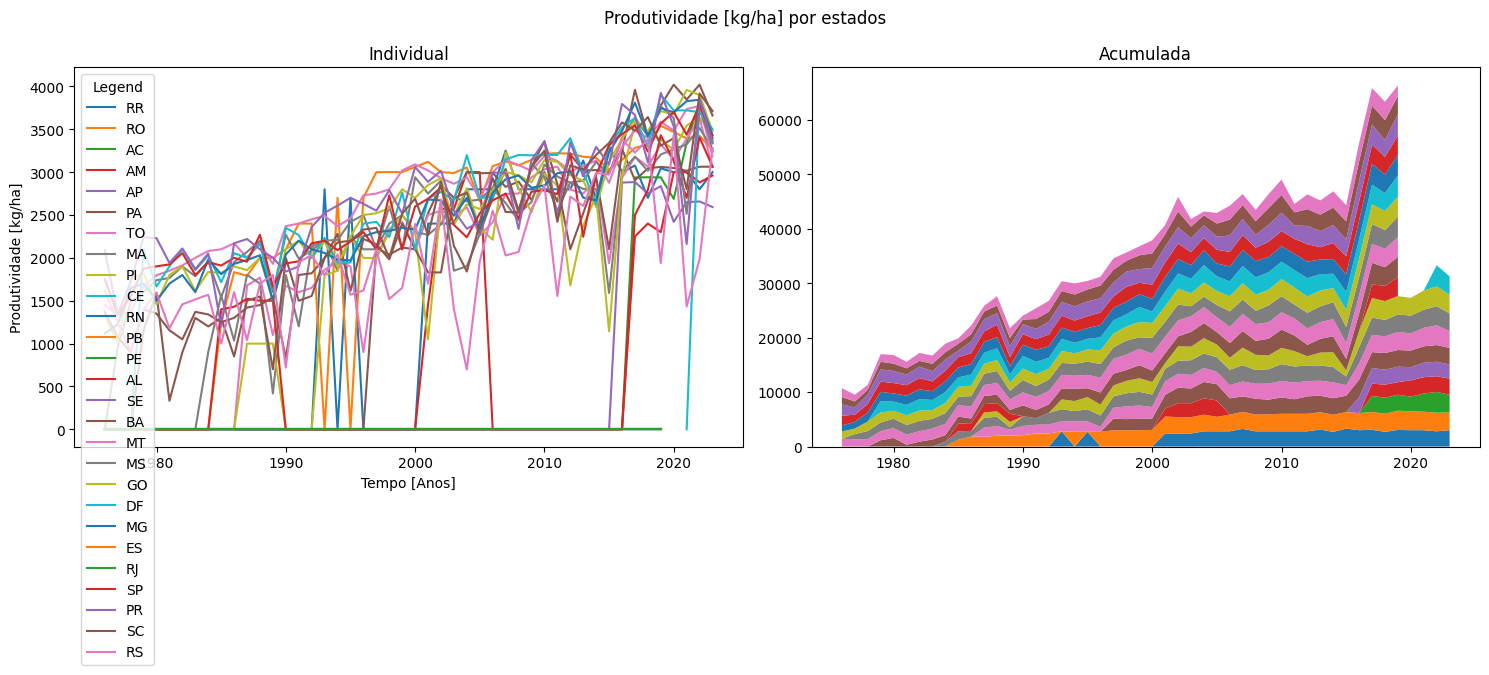

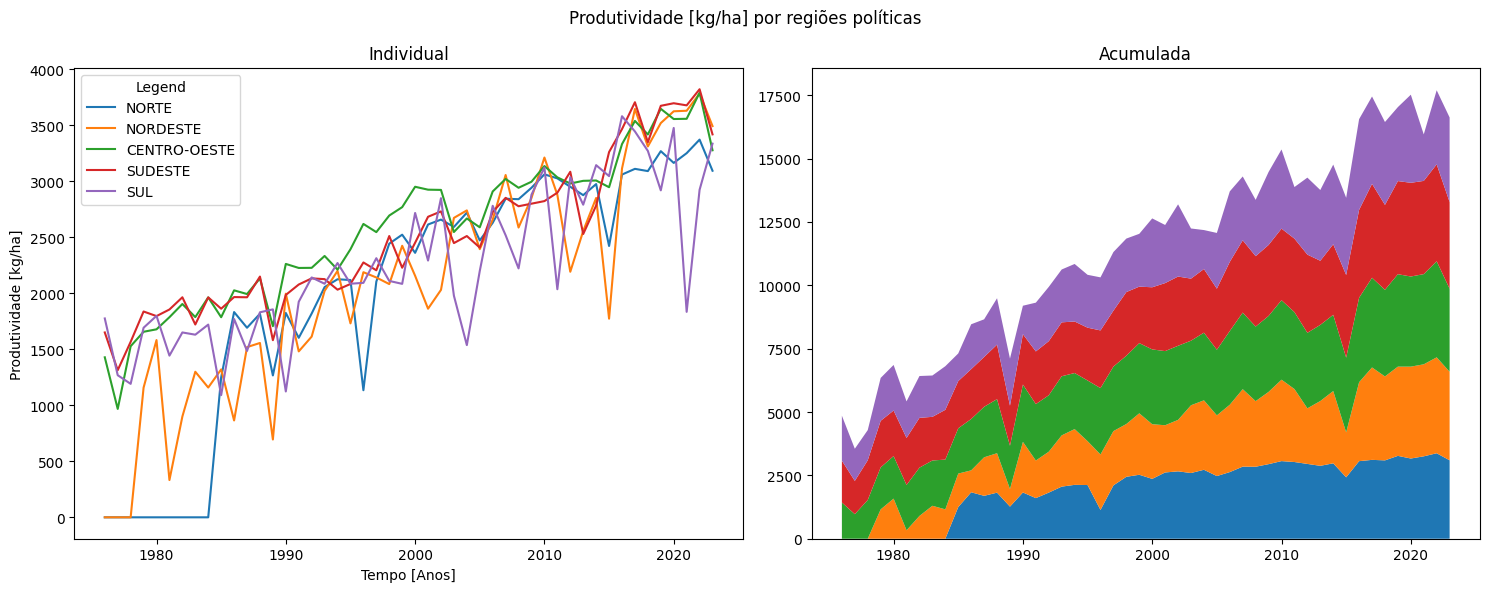

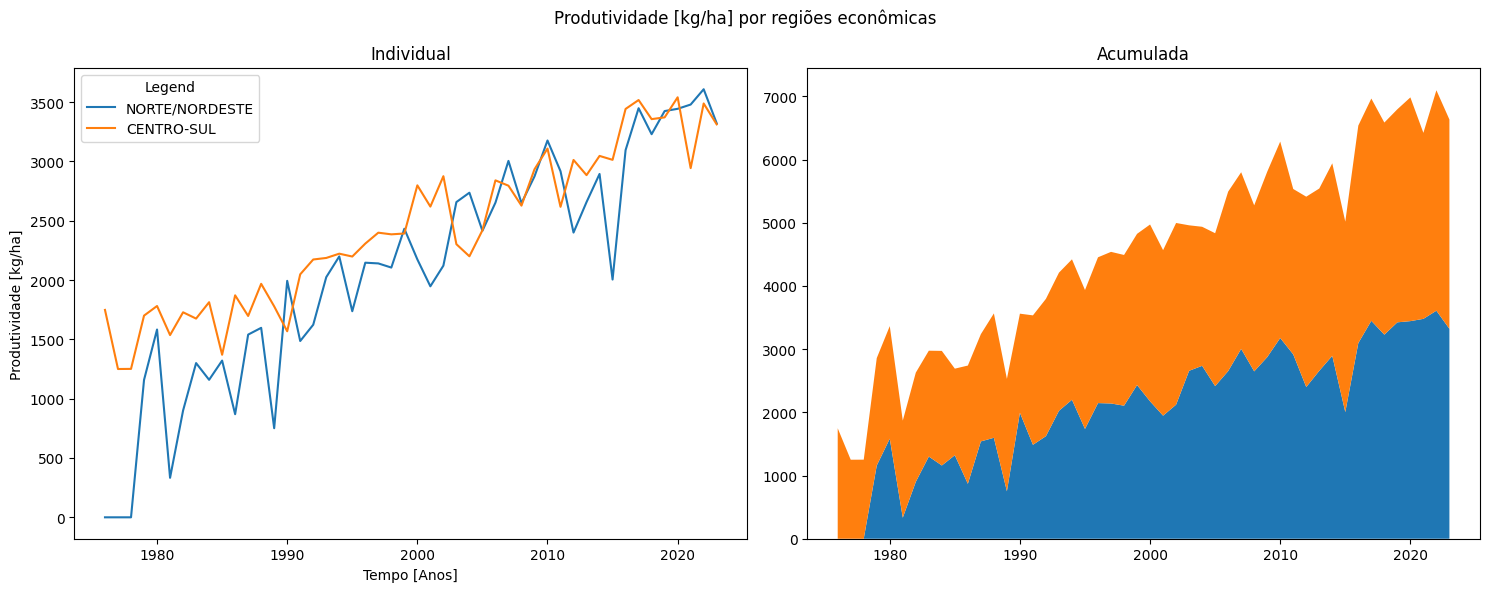

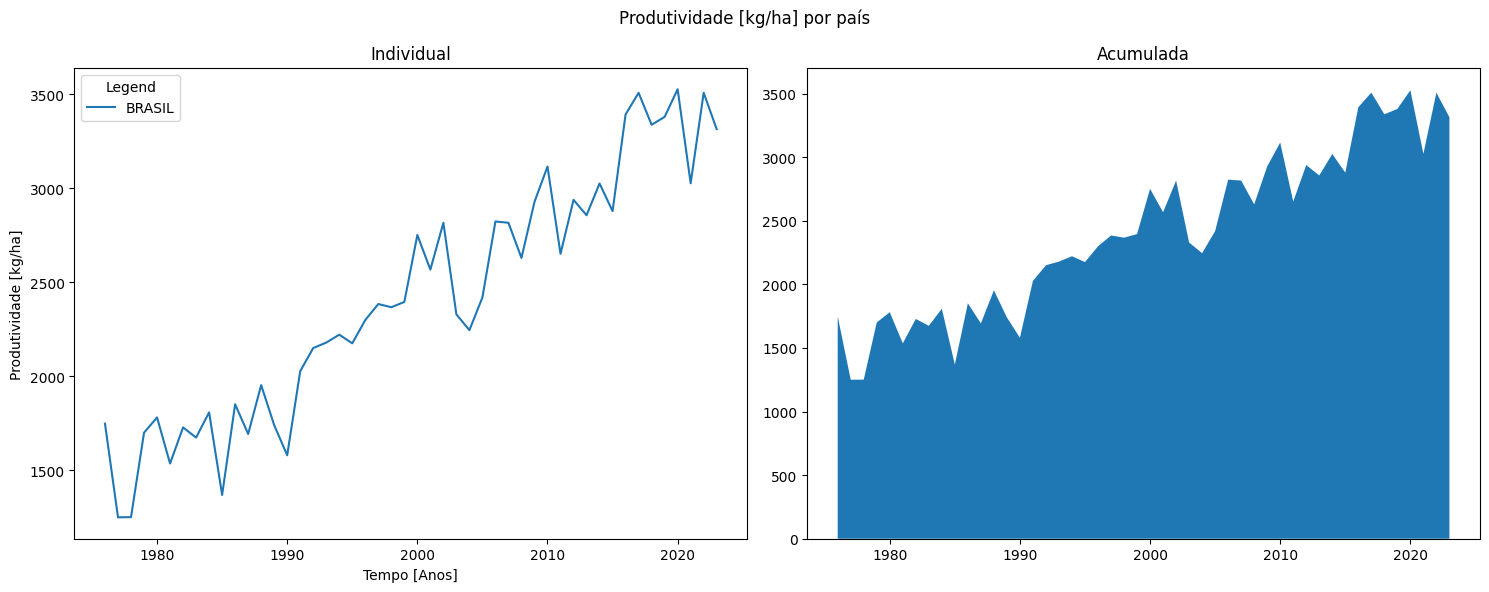

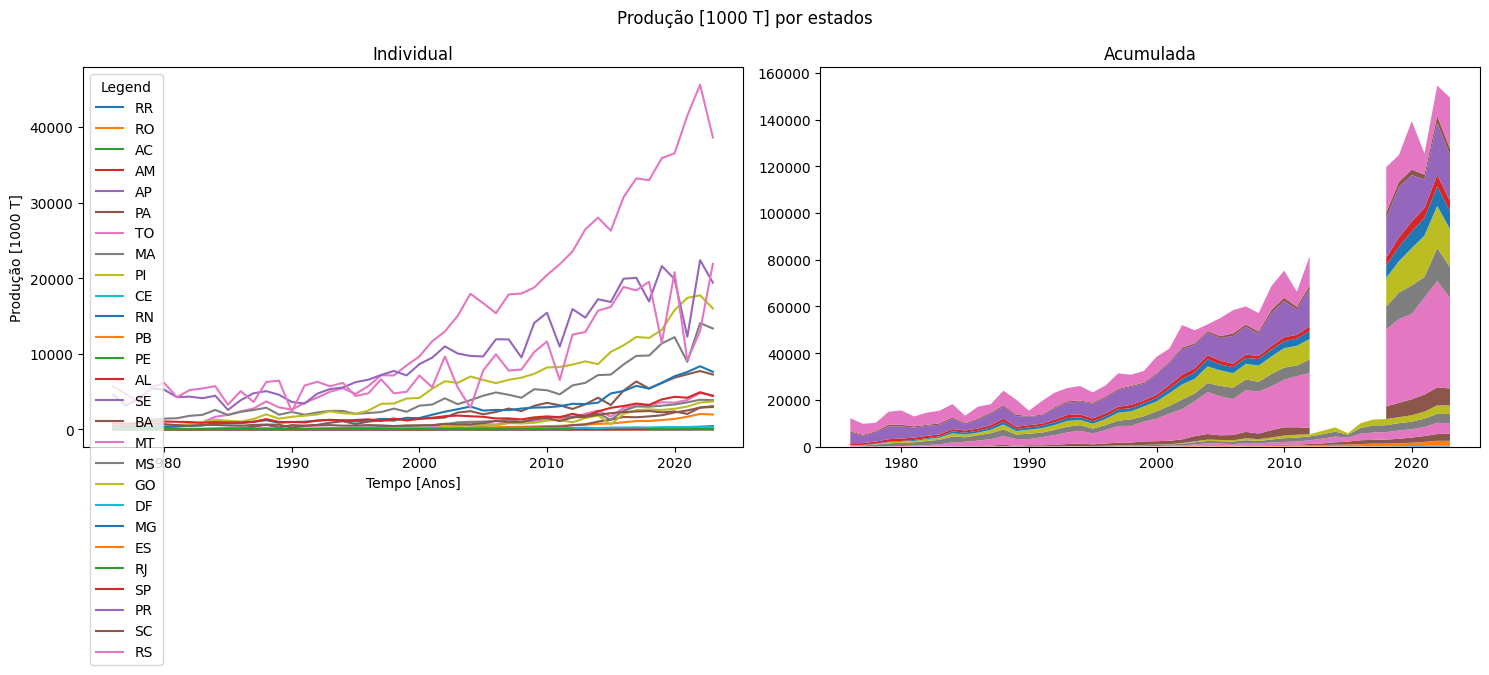

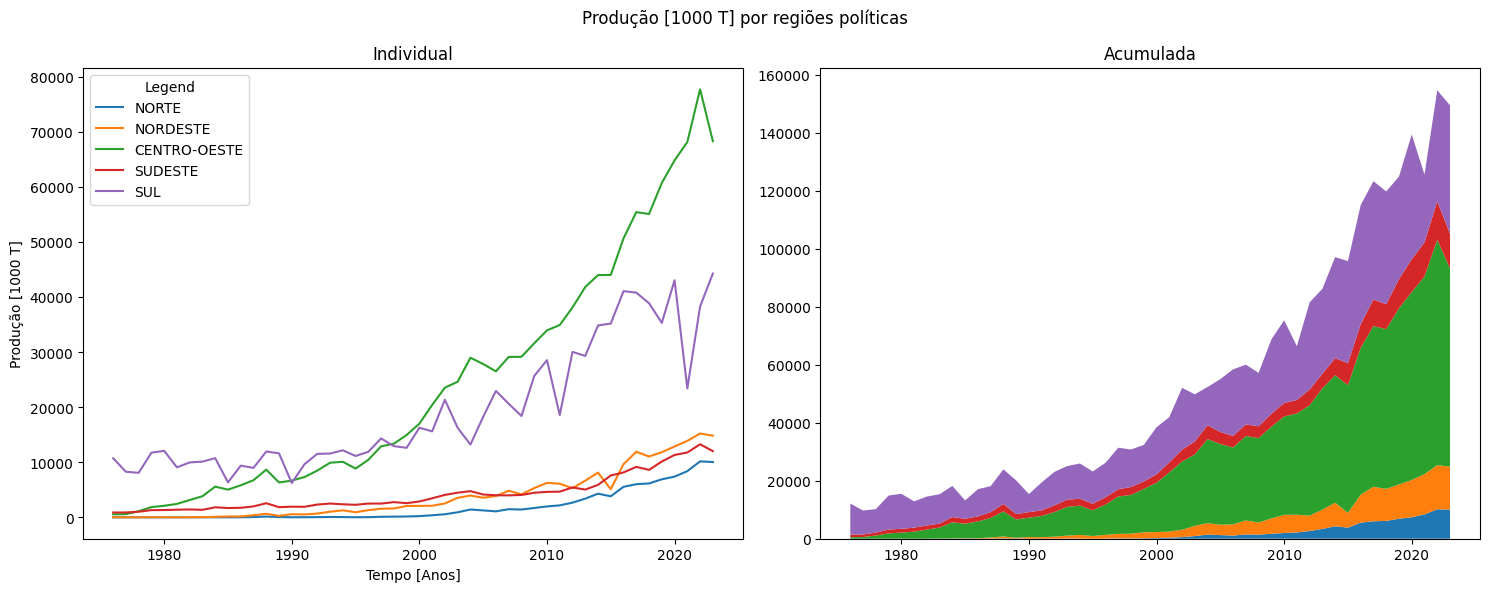

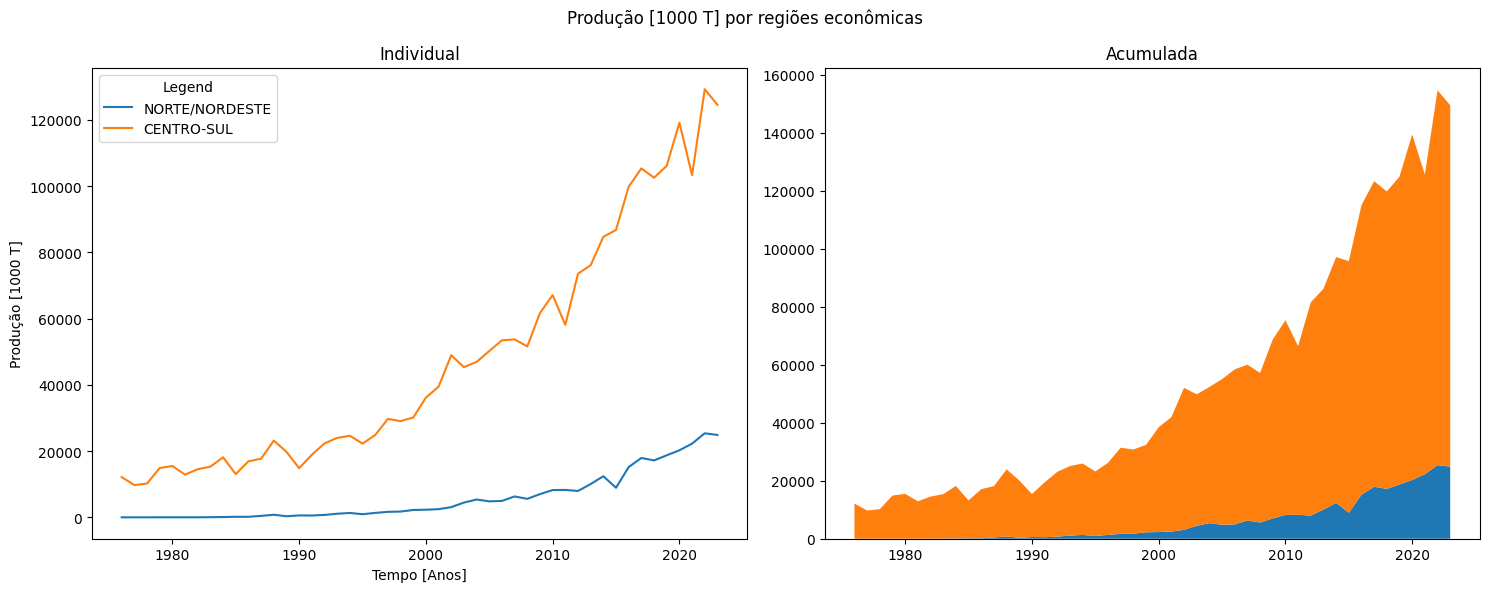

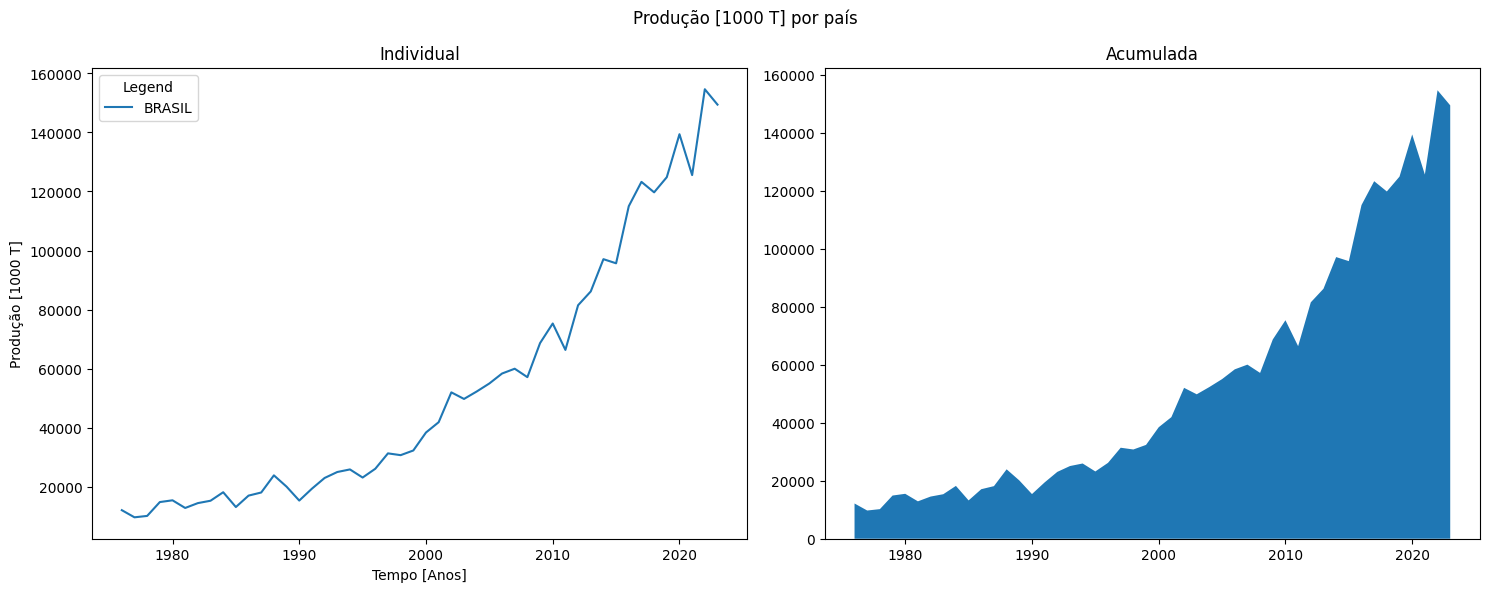

In [36]:
import matplotlib.pyplot as plt

df_soy = pd.read_csv(fpath + 'soy_area.csv', delimiter=',', encoding='utf8')
years = get_years(df_soy)

ylabels = [
    'Área plantada de soja [1000 hectares]', 
    'Produtividade [kg/ha]', 
    'Produção [1000 T]'
]

for ylabel, item in zip(ylabels, soy_data.items()):
    geodata_file = item[1]
    
    for label, geodata in geodata_file.items():
        plot_soy_data(label, years, geodata, ylabel)

## Questão 2

Faça um **cruzamento dos dados históricos de produtividade de soja com dados históricos climáticos** (principalmente temperatura e precipitação). 

Avalie a existência de correlações entre fatores climáticos e produtividade de soja.

Dados disponíveis em: https://portal.inmet.gov.br/dadoshistoricos
Janela de tempo: 2000-

In [76]:
def get_climate_filenames(climate_folder):
    return listdir(climate_folder)

def get_climate_file_uf(climate_file_):
    return climate_file_.split('_')[2]

def get_climate_ufs(climate_folder_path):
    climate_files = get_climate_filenames(climate_folder_path)
    
    return list(
        {
            get_climate_file_uf(climate_file)
            for climate_file in climate_files
        }
    )

def skip_row_count(input_file_path: str, output_file_path: str, row_count: str):

    # Read the input file into memory
    with open(input_file_path, 'r') as file:
        lines = file.readlines()

    # Skip the first 7 rows
    lines = lines[row_count:]

    # Write the remaining lines to the output file
    with open(output_file_path, 'w') as file:
        for line in lines:
            file.write(line)


def clean_df(df_):
    precipitacao_has_9999 = df_['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)']!='-9999'
    temperatura_has_9999 = df_['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)']!='-9999'
    
    cleanse_mask=precipitacao_has_9999 & temperatura_has_9999
    
    return df_[cleanse_mask]

def normalize_number(number_str):
    import locale
    
    # Set the locale to the user's default locale
    locale.setlocale(locale.LC_ALL, '')
    
    # Parse the number-like string to a float
    number = locale.atof(number_str)
    
    # Format the float back to a string using the user's locale
    normalized_number_str = locale.str(number)
    
    return normalized_number_str

def grouped_climate_info(df_, possible_time_columns, possible_time_delimiters, data_columns):
    col_precipitacao = data_columns[0]
    col_temperatura = data_columns[1]

    str_to_float = lambda x: float(str(x).replace(',', '.'))
    normalize_str = lambda x: float(str_to_float(normalize_number(str(x))))

    df_[col_temperatura] = df_[col_temperatura].apply(str_to_float)
    df_[col_precipitacao] = df_[col_precipitacao].apply(normalize_str)

    ano_col = 'ano'    
    for possible_time_delimiter, possible_time_column in zip(possible_time_delimiters, possible_time_columns):
        try:
            split_map = lambda x: float(str(x).split(possible_time_delimiter)[0])
            df_[ano_col] = df_[possible_time_column].apply(split_map)
            
            break;
        except Exception as e:
            pass
    
    return df_.groupby(ano_col).agg({
        col_precipitacao: 'sum',
        col_temperatura: ['mean', 'std']
    }).reset_index()


In [112]:
from os import listdir
from numpy import unique
from os import path

climate_data_path = getcwd()+'/data/climate/'

climate_years = sorted([int(year) for year in listdir(climate_data_path)])
climate_folder_paths = [climate_data_path+str(climate_year) for climate_year in climate_years]

climate_year_states = dict()

for climate_year, climate_folder_path in zip(climate_years, climate_folder_paths):
    climate_year_states[climate_year] = get_climate_ufs(climate_folder_path)

climate_year_data = {
    year: {
        state: dict() for state in states
    } for year, states  in climate_year_states.items()
}


In [79]:
# Run this cell iff your are testing
states = ['PI']
climate_years = [2019]
climate_folder_paths = ['/home/brunolnetto/Documents/spacetime_labs/data/climate/2019']
climate_year_states = {
    2019: ['PI']
}

climate_filenames= [
    'INMET_NE_PI_A336_ALVORADA DO GURGUEIA_01-01-2019_A_31-12-2019.CSV'
]

climate_year_data = {
    year: {
        state: dict() for state in states
    } for year, states  in climate_year_states.items()
}

climate_year_data

{2019: {'PI': {}}}

In [116]:
from tqdm import tqdm

# Specify the column names you want to read
time_columns = [
    'DATA (YYYY-MM-DD)', 'Data'
]

time_delimiters = [
    '-', '/'
]

data_columns = [
    'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)', 
    'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'
]


for climate_year, climate_folder_path in zip(climate_years, climate_folder_paths):
    climate_filenames = get_climate_filenames(climate_folder_path)
    
    for climate_filename in tqdm(climate_filenames):
        this_uf = get_climate_file_uf(climate_filename)

        # Read the file into a DataFrame (uses delimiter ';')
        datasource_path = path.join(climate_folder_path, climate_filename)
        this_uf = get_climate_file_uf(climate_filename)

        try:
            df = pd.read_csv(
                datasource_path, 
                skiprows=8,
                delimiter=';', 
                encoding='latin-1',
            )
            
            # Reset the index
            df.reset_index(drop=True, inplace=True)
            
            df = clean_df(df)
            
            climate_year_data[climate_year][this_uf] = grouped_climate_info(
                df, 
                time_columns, time_delimiters, data_columns
            )
        
        except Exception as e:
            print(f'Erro na leitura do arquivo {datasource_path}')
            print(type(e))
            print(e)

  9%|███▊                                      | 53/589 [00:05<00:57,  9.30it/s]


KeyboardInterrupt: 

In [88]:
climate_year_data_dict = {
    year: {
        state: {
            f'{df_tuple[0]} {df_tuple[1]}'.strip(): df_dict[0]
            for df_tuple, df_dict in df_state.to_dict().items()
            if df_tuple[0] != 'ano'
        }
        for state, df_state in climate_year_data[year].items()
    }
    for year in climate_year_data.keys()    
}
climate_year_data_dict

{2000: {'BA': {'PRECIPITAÇÃO TOTAL, HORÁRIO (mm) sum': 172.20000000000002,
   'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C) mean': 25.895893027698186,
   'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C) std': 1.9916122105828424},
  'AM': {'PRECIPITAÇÃO TOTAL, HORÁRIO (mm) sum': 738.4,
   'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C) mean': 26.734559841740854,
   'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C) std': 2.9268084048653775},
  'DF': {'PRECIPITAÇÃO TOTAL, HORÁRIO (mm) sum': 656.0,
   'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C) mean': 20.92558806655192,
   'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C) std': 4.000551232023049},
  'RJ': {'PRECIPITAÇÃO TOTAL, HORÁRIO (mm) sum': 524.2,
   'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C) mean': 22.580745709212863,
   'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C) std': 4.711458114570798},
  'RS': {'PRECIPITAÇÃO TOTAL, HORÁRIO (mm) sum': 401.8,
   'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C) mean': 20.856788566624633,
   'TEMPERATURA DO A

In [111]:
from IPython.display import display

climate_year_data_dict = {
    year: {
        state: {
            f'{df_tuple[0]} {df_tuple[1]}'.strip(): df_dict[0]
            for df_tuple, df_dict in df_state.to_dict().items()
            if df_tuple[0] != 'ano'
        }
        for state, df_state in climate_year_data[year].items()
    }
    for year in climate_year_data.keys()    
}

climate_year_data_df = {
    'ano': [],
    'estado': [],
    'PRECIPITAÇÃO TOTAL, HORÁRIO (mm) sum': [], 
    'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C) mean': [],
    'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C) std': []
}

for year, year_data in climate_year_data_dict.items():
    for state, state_data in climate_year_data_dict[year].items():
        climate_year_data_df['ano'].append(year)
        climate_year_data_df['estado'].append(state)
        
        for key, value in climate_year_data_dict[year][state].items():
            climate_year_data_df[key].append(value)

climate_year_data_df = pd.DataFrame(climate_year_data_df)
climate_year_data_df = climate_year_data_df.sort_values(['ano', 'estado'])

climate_year_data_df.columns = [
    'ano', 
    'estado', 
    'precipitacao_anual_mm', 
    'temperatura_media_anual_oC', 
    'desvio_temperatura_media_anual_oC', 
]

climate_year_data_df[climate_year_data_df['temperatura_media_anual_oC'].isna()]

,ano,estado,precipitacao_anual_mm,temperatura_media_anual_oC,desvio_temperatura_media_anual_oC
470,2020,MS,0.0,NaN,NaN
476,2020,PB,0.0,NaN,NaN
487,2021,AC,0.0,NaN,NaN
502,2021,AL,0.0,NaN,NaN
499,2021,AM,0.0,NaN,NaN
490,2021,AP,0.0,NaN,NaN
504,2021,CE,0.0,NaN,NaN
488,2021,MA,0.0,NaN,NaN
497,2021,MS,0.0,NaN,NaN
500,2021,MT,0.0,NaN,NaN


In [121]:
corruted_data_mask = ~climate_year_data_df['temperatura_media_anual_oC'].isna()
climate_year_data_df[corruted_data_mask]

,ano,estado,precipitacao_anual_mm,temperatura_media_anual_oC,desvio_temperatura_media_anual_oC
1,2000,AM,738.4,26.734560,2.926808
0,2000,BA,172.2,25.895893,1.991612
2,2000,DF,656.0,20.925588,4.000551
3,2000,RJ,524.2,22.580746,4.711458
4,2000,RS,401.8,20.856789,4.791744
...,...,...,...,...,...
567,2024,RR,11.0,29.909722,3.404927
577,2024,RS,319.2,25.078561,3.699770
587,2024,SC,204.8,21.766875,3.892277
586,2024,SP,664.2,22.513958,3.764884


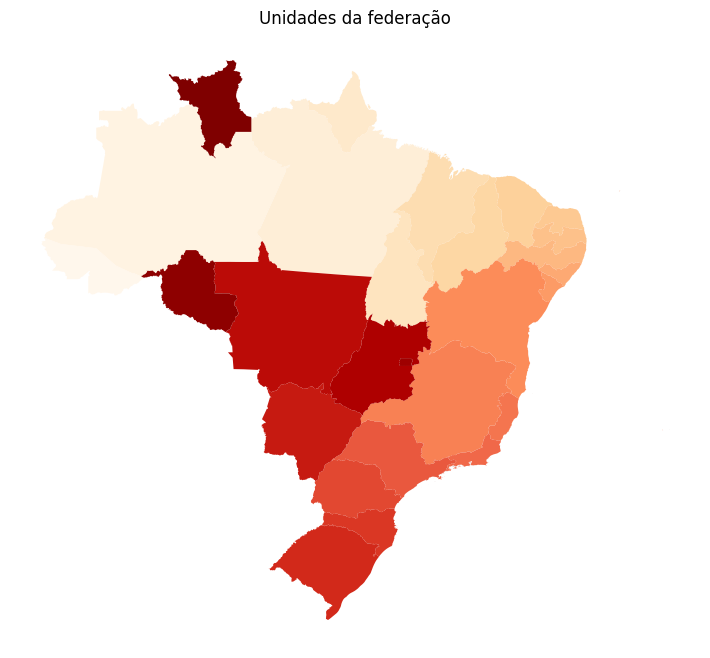

In [14]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Certifique-se de ter o arquivo "BR_UF_2021.shp" em seu diretório ou ajuste o caminho conforme necessário
shapes_path = getcwd()+"/data/shapes/BR_UF_2022.shp"
estados = gpd.read_file(shapes_path)

# Substitua "data" pelo seu DataFrame contendo os dados para a coropleta
# Substitua "column" pelo nome da coluna contendo os dados a serem visualizados
estados.plot(cmap="OrRd", legend=True, figsize=(12, 8))

plt.title("Unidades da federação")
plt.axis("off")

plt.show()


